In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import sklearn.metrics as metrics

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import pickle

In [24]:
class BayesianCNNold(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 1.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 128)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([128, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([128]).to_event(1))

        # Fully connected layer 2 (classifier)
        self.fc2 = PyroModule[nn.Linear](128, 10)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([10, 128]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        with pyro.plate("data", x.size(0)):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits


In [25]:
class BayesianCNNoldtoo(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 1.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 128)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([128, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([128]).to_event(1))

        # Fully connected layer 2 (classifier)
        self.fc2 = PyroModule[nn.Linear](128, 10)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([10, 128]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        if y is not None:
            # During training: observe the labels
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        # Always return logits (training or inference)
        return logits


In [26]:
class BayesianCNN(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 1.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer (output layer)
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 10)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([10, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)  # No intermediate layer

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits

In [27]:
class BayesianCNN5(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 5.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 5.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 5.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 5.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer (output layer)
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 10)
        self.fc1.weight = PyroSample(dist.Normal(0., 5.).expand([10, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 5.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)  # No intermediate layer

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits

In [28]:
class BayesianCNN10(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 10.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 10.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 10.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 10.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer (output layer)
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 10)
        self.fc1.weight = PyroSample(dist.Normal(0., 10.).expand([10, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)  # No intermediate layer

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits

In [29]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=True)


    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    #with open('datasplit/split_indices.pkl', 'rb') as f:
    #    split = pickle.load(f)
    #    train_dataset = Subset(dataset, split['train'])
    #    test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [30]:
class BayesianCNN5_2FC(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 5.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 5.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 5.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 5.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 128)
        self.fc1.weight = PyroSample(dist.Normal(0., 5.).expand([128, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 5.).expand([128]).to_event(1))

        # Fully connected layer 2 (classifier)
        self.fc2 = PyroModule[nn.Linear](128, 10)
        self.fc2.weight = PyroSample(dist.Normal(0., 5.).expand([10, 128]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 5.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        with pyro.plate("data", x.size(0)):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deterministic_CNN_2FC(nn.Module):
    def __init__(self):
        super().__init__()

        # Deterministic Conv2d layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)

        # Deterministic Conv2d layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1
        self.fc1 = nn.Linear(64 * 16 * 16, 128)

        # Fully connected layer 2 (classifier)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [32]:
## 


## Initiate the Weight from the trained CNN

In [33]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroParam

def initialize_pyro_from_cnn_OLD(pyro_model, cnn_model, init_std=0.1):
    for pyro_name, pyro_module in pyro_model.named_modules():
        if isinstance(pyro_module, PyroModule[nn.Linear]) or isinstance(pyro_module, PyroModule[nn.Conv2d]):
            # Get the matching deterministic module
            try:
                cnn_module = dict(cnn_model.named_modules())[pyro_name]
            except KeyError:
                continue

            # Replace priors with posterior parameters (variational)
            weight = cnn_module.weight.data
            bias = cnn_module.bias.data

            # Register variational parameters manually
            pyro_module.weight = PyroSample(dist.Normal(
                PyroParam(weight.clone(), constraint=dist.constraints.real),
                PyroParam(torch.full_like(weight, init_std), constraint=dist.constraints.positive)
            ).to_event(weight.dim()))

            pyro_module.bias = PyroSample(dist.Normal(
                PyroParam(bias.clone(), constraint=dist.constraints.real),
                PyroParam(torch.full_like(bias, init_std), constraint=dist.constraints.positive)
            ).to_event(1))

In [34]:
def initialize_pyro_from_cnn(guide, pyro_model, cnn_model, init_std=0.1):
    from pyro.nn import pyro_method  # Needed for guide structure

    # Extract parameter tensors from the guide
    guide_params = dict(guide.named_parameters())

    for (name, pyro_module), (_, cnn_module) in zip(pyro_model.named_modules(), cnn_model.named_modules()):
        if isinstance(pyro_module, (PyroModule[nn.Conv2d], PyroModule[nn.Linear])):
            for param_type in ['weight', 'bias']:
                cnn_param = getattr(cnn_module, param_type, None)
                if cnn_param is None:
                    continue

                pyro_param_name_loc = f"{name}.{param_type}_loc"
                pyro_param_name_scale = f"{name}.{param_type}_scale"

                if pyro_param_name_loc in guide_params:
                    with torch.no_grad():
                        guide_params[pyro_param_name_loc].copy_(cnn_param.data)
                        guide_params[pyro_param_name_scale].fill_(init_std)


In [35]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal, AutoGaussian
from tqdm.auto import trange
pyro.clear_param_store()

In [36]:
#model = BayesianCNN5_2FC()  # 
model = BayesianCNN10() # 1 FC ==> 39.26%
#model = BayesianCNN5() # 1 FC ==> 46.57%
#model = BayesianCNN() # 1 FC ==> 34.7%
#model = BayesianCNNoldtoo() # 2 FC ==> 11.23%

#SCRIPT : gaussian 26.47%
#SCRIPT: laplace 23.20%

# Set Pyro random seed
pyro.set_rng_seed(42)

In [37]:
INITIATE_GUIDE = True

if INITIATE_GUIDE:

    deterministic_model = Deterministic_CNN_2FC()
    deterministic_model.load_state_dict(torch.load("results_eurosat/cnn_model.pth", map_location="cpu"))

    mean_field_guide = AutoDiagonalNormal(model)
    initialize_pyro_from_cnn(mean_field_guide,model, deterministic_model, init_std=1)

else:

    mean_field_guide = AutoDiagonalNormal(model)

In [38]:
train_loader, test_loader = load_data()

In [39]:
# show one sample of train data in matplotlib
import matplotlib.pyplot as plt
def show_sample(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.permute(0, 2, 3, 1).numpy() * 0.1137 + 0.4082  # Convert to (B, H, W, C)
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

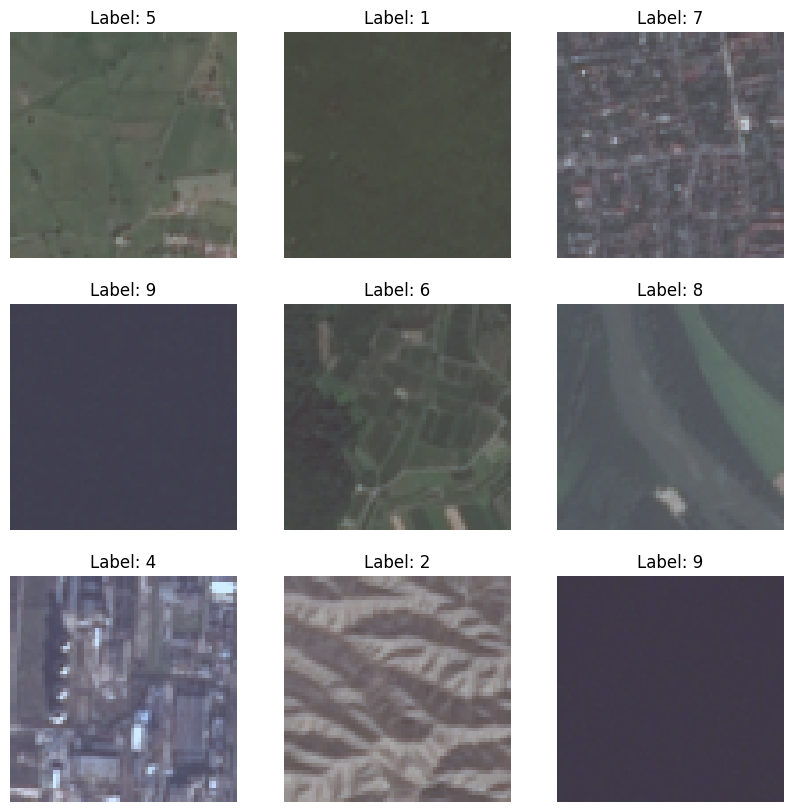

In [40]:
show_sample(train_loader)

In [41]:
#mean_field_guide = AutoDiagonalNormal(model)
#mean_field_guide = AutoGaussian(model)
optimizer = pyro.optim.Adam({"lr": 1e-4}) #initially 1e-2

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 10
progress_bar = trange(num_epochs)

#full_batch = next(iter(train_loader))
#x_train, y_train = full_batch

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
#for epoch in progress_bar:
#    loss = svi.step(x_train, y_train)
#    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

In [43]:
#for x_train, y_train in train_loader:
#    print("test")

In [44]:
#diemdah

In [45]:
epoch_loss_list = []
epoch_train_accuracy_list = []

for epoch in progress_bar:
    epoch_loss = 0
    for x_train, y_train in train_loader:
        loss = svi.step(x_train, y_train)
        epoch_loss += loss
    #progress_bar.set_postfix(loss=f"{epoch_loss / len(train_loader.dataset):.3f}")
    # show train accuracy, not test accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        #for x_test, y_test in test_loader:
        logits = model(x_train)
        _, predicted = torch.max(logits, 1)
        total += y_train.size(0)
        correct += (predicted == y_train).sum().item()
        accuracy = correct / total
        progress_bar.set_postfix(loss=f"{epoch_loss / len(train_loader.dataset):.3f}", accuracy=f"{accuracy:.3f}")

    # save the loss and accuracy for each epoch in the list
    epoch_loss_list.append(epoch_loss / len(train_loader.dataset))
    epoch_train_accuracy_list.append(accuracy)

# save the model
torch.save(model.state_dict(), 'pyro_result/bayesian_cnn_10.pth')

100%|██████████| 10/10 [11:47<00:00, 70.77s/it, accuracy=0.093, loss=176880.192]


In [46]:
#torch.save(mean_field_guide.state_dict(), 'pyro_result/mean_field_guide.pth')

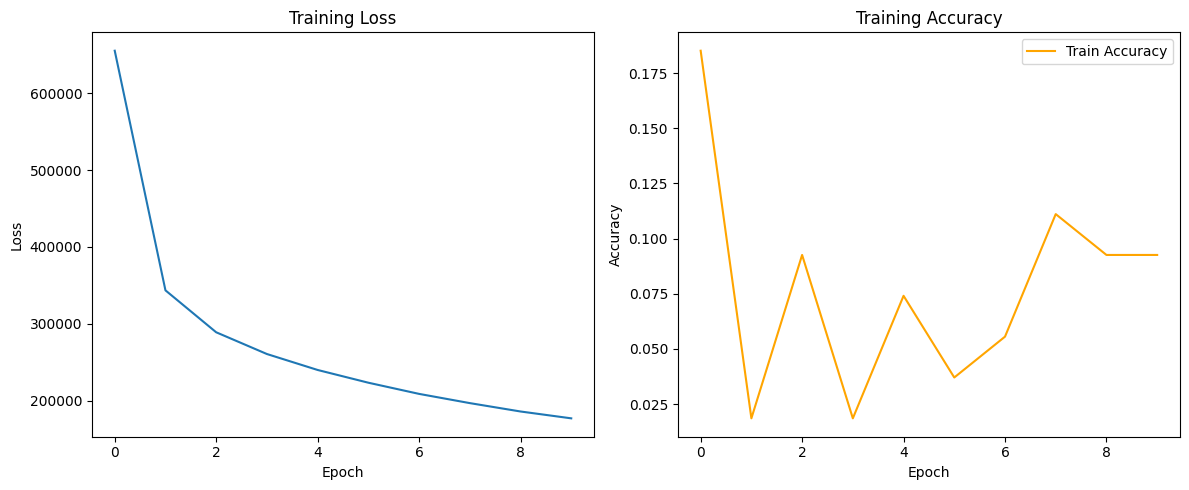

In [47]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(epoch_train_accuracy_list, label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('pyro_result/bayesian_cnn_training.png')
plt.show()

In [48]:
from pyro.infer import Predictive

In [49]:
#train_loader, test_loader = load_data()
#x_test, y_test = next(iter(test_loader))

#predictive = Predictive(model, guide=mean_field_guide, num_samples=10)
#preds = predictive(x_test)

In [50]:
from tqdm import tqdm

In [51]:
#train_loader, test_loader = load_data()
#x_test, y_test = next(iter(test_loader))
#predictive = Predictive(model, guide=mean_field_guide, num_samples=10)

#all_preds = []
#all_labels = []

#for x_batch, y_batch in tqdm(test_loader):
#    batch_preds = predictive(x_batch)["obs"]  # shape: (num_samples, batch_size, ...)
#    mean_preds = batch_preds.float().mean(dim=0).values      # shape: (batch_size, ...)
#    all_preds.append(mean_preds)
#    all_labels.append(y_batch)

# Concatenate along the batch dimension
#all_preds = torch.cat(all_preds, dim=0)   # shape: (total_test_samples, ...)
#all_labels = torch.cat(all_labels, dim=0) # shape: (total_test_samples, ...)

In [52]:
train_loader, test_loader = load_data()
#x_test, y_test = next(iter(test_loader))
predictive = Predictive(model, guide=mean_field_guide, num_samples=5, return_sites=["_RETURN"])

all_preds = []
all_labels = []

for x_batch, y_batch in tqdm(test_loader):
    batch_preds = predictive(x_batch)["_RETURN"]  # shape: (num_samples, batch_size, ...)
    batch_preds = torch.softmax(batch_preds, dim=-1)
    mean_preds = batch_preds.float().mean(dim=0).squeeze()  # shape: (batch_size, num_classes)
    mean_preds = mean_preds.argmax(dim=1)  # shape: (batch_size,)
    all_preds.append(mean_preds)
    all_labels.append(y_batch)

# Concatenate along the batch dimension
all_preds = torch.cat(all_preds, dim=0)   # shape: (total_test_samples, ...)
all_labels = torch.cat(all_labels, dim=0) # shape: (total_test_samples, ...)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


In [53]:
#batch_preds[0].sum(dim=1)  # shape: (batch_size, num_classes)

In [54]:
#predictive(x_batch)["_RETURN"].float().mean(dim=0)

In [55]:
#predictive(x_batch)["_RETURN"].float().mean(dim=0).squeeze().argmax(dim=1)

In [56]:
import sklearn.metrics as metrics

In [60]:

# Calculate accuracy  
accuracy = metrics.accuracy_score(all_labels.numpy(), all_preds.numpy())
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.3528


In [58]:
mendingludiemdeh

NameError: name 'mendingludiemdeh' is not defined

In [ ]:
#torch.save({"model" : model.state_dict(), "guide" : mean_field_guide}, "pyro_result/mymodel.pt")
#pyro.get_param_store().save("pyro_result/mymodelparams.pt")

In [ ]:
torch.save(pyro.get_param_store(), 'pyro_result/mymodelparams.pth')

In [ ]:
pyro.get_param_store().save('pyro_result/mymodelparams.pth')

In [ ]:
pyro.get_param_store().load('pyro_result/mymodelparams.pth')

In [ ]:
# load the model and redo the inference
model = BayesianCNN()
model.load_state_dict(torch.load('pyro_result/bayesian_cnn_10.pth'))
model.eval()

mean_field_guide_loaded = AutoDiagonalNormal(model)
mean_field_guide_loaded.load_state_dict(torch.load('pyro_result/mean_field_guide.pth'))
# Re-run the inference with the loaded model
predictive = Predictive(model, guide=mean_field_guide_loaded, num_samples=5,
                        return_sites=["_RETURN"])
all_preds = []
all_labels = []
for x_batch, y_batch in tqdm(test_loader):
    batch_preds = predictive(x_batch)["_RETURN"]  # shape: (num_samples, batch_size, ...)
    batch_preds = torch.softmax(batch_preds, dim=-1)
    mean_preds = batch_preds.float().mean(dim=0).squeeze()  # shape: (batch_size, num_classes)
    mean_preds = mean_preds.argmax(dim=1)  # shape: (batch_size,)
    all_preds.append(mean_preds)
    all_labels.append(y_batch)

# Concatenate along the batch dimension
all_preds = torch.cat(all_preds, dim=0)   # shape: (total_test_samples, ...)
all_labels = torch.cat(all_labels, dim=0) # shape: (total_test_samples, ...)
# Calculate accuracy
accuracy = metrics.accuracy_score(all_labels.numpy(), all_preds.numpy())
print(f"Test Accuracy after loading model: {accuracy:.4f}")

In [ ]:
# SHOW one sample of the image with the transformation and the prediction


import matplotlib.pyplot as plt
import numpy as np
def show_sample(x, y_true, y_pred):
    #images.permute(0, 2, 3, 1).numpy() * 0.1137 + 0.4082
    #plt.imshow(np.transpose(x.numpy(), (1, 2, 0)))
    plt.imshow(x.permute(1, 2, 0).numpy() * 0.1137 + 0.4082)
    plt.title(f"True: {y_true}, Predicted: {y_pred}")
    plt.axis('off')
    plt.show()


In [ ]:

# Show a sample from the test set
sample_index = 5399  # Change this to show different samples
x_sample, y_sample = test_loader.dataset[sample_index]
y_pred_sample = all_preds[sample_index].item()
show_sample(x_sample, y_sample, y_pred_sample)

In [ ]:
# show confusion matrix
import seaborn as sns
confusion_matrix = metrics.confusion_matrix(all_labels.numpy(), all_preds.numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# show the sample category distribution in train and test set
import pandas as pd
def show_category_distribution(loader, title):
    labels = []
    for _, y in loader:
        labels.extend(y.numpy())
    label_counts = pd.Series(labels).value_counts().sort_index()
    
    plt.figure(figsize=(10, 5))
    label_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
#show_category_distribution(train_loader, 'Train Set Category Distribution')
#show_category_distribution(test_loader, 'Test Set Category Distribution')

In [ ]:
train_loader, test_loader = load_data()

In [ ]:
from pyro.infer import Predictive
import numpy as np
from tqdm import tqdm

num_samples = 10
predictive = Predictive(model, guide=mean_field_guide, num_samples=num_samples, return_sites=["_RETURN"])

print('Prediction when network is forced to predict')
correct = 0
total = 0

for images, labels in tqdm(test_loader):
    # Get num_samples predictions for this batch
    batch_preds = predictive(images)["_RETURN"]  # shape: (num_samples, batch_size, num_classes)
    batch_preds = torch.softmax(batch_preds, dim=-1)  # convert logits to probabilities
    mean_preds = batch_preds.mean(dim=0)  # shape: (batch_size, num_classes)
    predicted = mean_preds.argmax(dim=1).cpu().numpy()
    total += labels.size(0)
    correct += (predicted == labels.cpu().numpy()).sum()

print("accuracy: %d %%" % (100 * correct / total))

In [ ]:
KATAGUEDIEMDEH

In [ ]:
accuracy

In [ ]:
# predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
# Get full x_test from DataLoader
# x_test, y_test = next(iter(test_loader))
# preds = predictive(x_test)

In [ ]:
stopdeh

In [ ]:
preds["obs"].shape

In [ ]:
import numpy as np

In [ ]:
all_preds = np.concatenate(preds["obs"], axis=0)
all_preds

In [ ]:
from pyro.infer import MCMC, NUTS

model = BayesianCNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

train_loader, test_loader = load_data()

# Get one full batch (the entire dataset)
full_batch = next(iter(train_loader))
x_batch, y_batch = full_batch

# Run MCMC on the full dataset
#mcmc.run(x_batch, y_batch) ==> this will take a while, so we comment it out